In [4]:
%matplotlib inline
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = pd.read_csv('data/labeledTrainData.tsv', sep='\t')
X = data.review.as_matrix()
y = data.sentiment.as_matrix() 
del data['id']
data.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


Разбейте выборку на train и test. Оставьте в test 4000 текстов. Для этого удобно воспользоваться <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">train_test_split</a>

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=4000, random_state=0, stratify=y)

Примените <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a>, чтобы превратить тексты в векторы чисел. <br>Вектор для текста имеет длину N, где N - количество различных слов в наших данных. Элемент вектора - число, определяющее, сколько раз слово i употреблялось в данном тексте.
Имеет смысл убрать стоп-слова. Это можно сделать параметром stop_words='english'

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_bag = vectorizer.fit_transform(X_train)
X_test_bag = vectorizer.transform(X_test)

Постройте RF, Logistic Regression, KNN. Посчитайте score на тестовой выборке

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
classifiers = {'RandomForestClassifier': RandomForestClassifier(random_state=42),
               'LogisticRegression': LogisticRegression(random_state=42),
               'KNeighborsClassifier': KNeighborsClassifier()}

In [7]:
%%time
for name, clf in classifiers.iteritems():
    clf.fit(X_train_bag, y_train)
    print name, '\t', clf.score(X_test_bag, y_test)

LogisticRegression 	0.8775
KNeighborsClassifier 	0.59975
RandomForestClassifier 	0.758
CPU times: user 16.4 s, sys: 1.91 s, total: 18.3 s
Wall time: 19.2 s


Выберете 1500 самых частых слов и создайте новые выборки из них

In [8]:
most_frequent = argsort(sum(X_train_bag.A, axis=0))[::-1][:1500]
X_train_frequent = X_train_bag[:, most_frequent]
X_test_frequent = X_test_bag[:, most_frequent]

Обучите RF, Logistic Regression, KNN на новых выборках.

In [9]:
%%time
for name, clf in classifiers.iteritems():
    clf.fit(X_train_frequent, y_train)
    print name, '\t', clf.score(X_test_frequent, y_test)

LogisticRegression 	0.84975
KNeighborsClassifier 	0.60525
RandomForestClassifier 	0.76275
CPU times: user 10.8 s, sys: 1.29 s, total: 12 s
Wall time: 12.5 s


Посчитайте f1-меру ошибки каждого алгоритма. Для этого удобно воспользоваться <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">f1_score</a>

In [17]:
from sklearn.metrics import f1_score
for name, clf in classifiers.iteritems():
    print name, '\t', \
        f1_score(y_test.astype(float), clf.predict(X_test_frequent))

LogisticRegression 	0.85112707456
KNeighborsClassifier 	0.583267352864
RandomForestClassifier 	0.748209074025


Постройте *precision-recall* и *roc* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

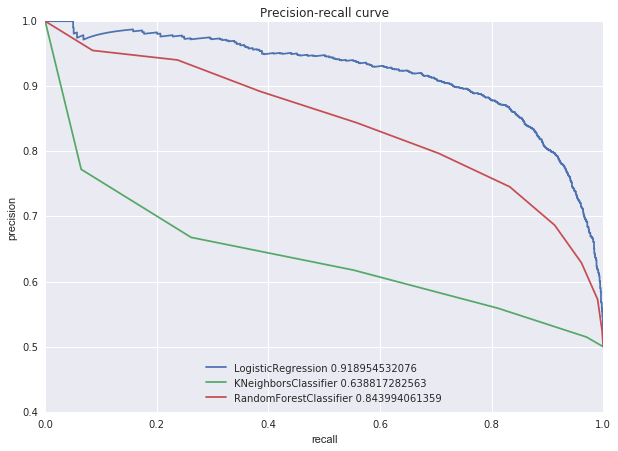

In [20]:
from sklearn.metrics import auc

figure(figsize=(10,7))
from sklearn.metrics import precision_recall_curve
for name, clf in classifiers.iteritems():
    
    precision, recall, thresh = \
        precision_recall_curve(y_test, clf.predict_proba(X_test_frequent)[:,1])
        
    plot(recall, precision, label=name + ' ' + str(auc(recall, precision)))
    
xlabel('recall')
ylabel('precision')
title('Precision-recall curve')
legend(loc='lower center');

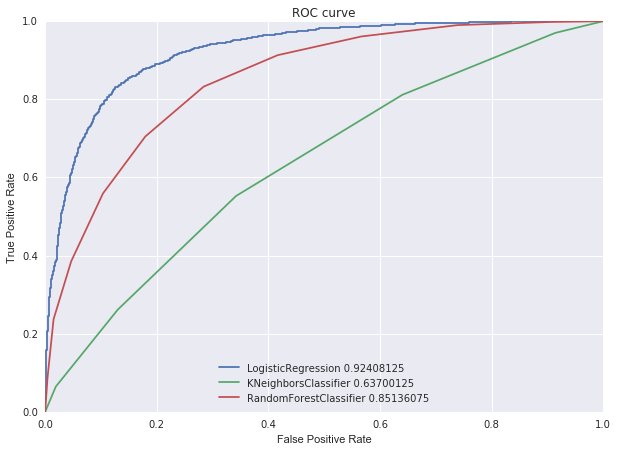

In [21]:
figure(figsize=(10,7))
from sklearn.metrics import roc_curve
for name, clf in classifiers.iteritems():
    
    fpr, trp, thresh = \
        roc_curve(y_test, clf.predict_proba(X_test_frequent)[:,1])
    plot(fpr, trp, label=name + ' ' +  str(auc(fpr, trp)))

xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('ROC curve')
legend(loc='lower center');

Воспользуйтесь <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html">TF-IDF кодированием</a>. Улучшился ли скор?

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [10]:
%%time
for name, clf in classifiers.iteritems():
    clf.fit(X_train_tf_idf, y_train)
    print name, '\t', clf.score(X_test_tf_idf, y_test)

LogisticRegression 	0.8905
KNeighborsClassifier 	0.78225
RandomForestClassifier 	0.7545
CPU times: user 13.5 s, sys: 2.58 s, total: 16.1 s
Wall time: 19.3 s


(*)Разбейте данные на 5 фолдов и подберите параметры у лучшего из алгоритмов. Улучшились ли AUC ROC, AUC PRC?

(*)Попробуйте другие варианты выбора 1500 слов:

1) Постройте RF на всех словах (а не на 1500). С помощью feature\_importance\_ выберете 1500 слов, которые наиболее важны для классификации. Постройте все вышеуказанные алгоритмы на них. Улучшились ли результаты?

2) Постройте LogisticRegression с l1-нормализацией. Подберите параметр C таким образом, чтобы ненулевыми остались 1500 весов. Пересчитайте AUC ROC, AUC PRC